# Burger's Inviscid/Non-Linear Advection

$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = 0
$$

with 
$$
u(x, 0) = \begin{cases}
    1 & x < \pi/2\\
    sin(x) & \pi/2 \le x \le 3\pi/2\\
    -1 & x > 3\pi/2
\end{cases}
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
TMAX = 10
GRID_LENGTH = 2*np.pi*4

In [4]:
# Define the initial signal that is being advected
def signal(x):
    u = np.zeros_like(x)
    lower = x < np.pi/2
    upper = x > 3*np.pi/2
    inside = np.logical_not(np.logical_or(lower, upper))
    u[lower] = 1
    u[upper] = -1
    u[inside] = np.sin(x[inside])
    return u
def signal2(x):
    u = np.zeros_like(x)
    lower = x < np.pi/2
    upper = x > 3*np.pi/2
    inside = np.logical_not(np.logical_or(lower, upper))
    u[lower] = 0
    u[upper] = 0
    u[inside] = -np.cos(x[inside])
    return u

In [5]:
def plot_opts(ax, max_x):
    ticks = np.arange(0, max_x + np.pi/2, np.pi/2)
    make_label = lambda p: '$%.1f\pi$' % (p/np.pi)
    labels = list(map(make_label, ticks))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.grid()

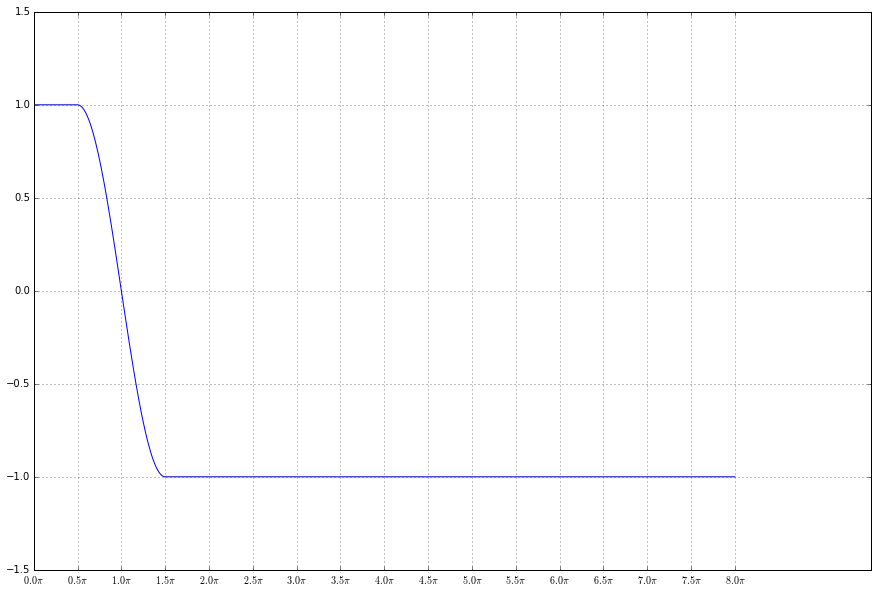

In [6]:
# Making sure our signal function is correct. 
fig, ax = plt.subplots(figsize=(15, 10))
x0 = np.linspace(0, GRID_LENGTH, 500)
u0 = signal(x0)
ax.plot(x0, u0)
ax.set_ylim(-1.5, 1.5)
plot_opts(ax, max(x0))
plt.show()

The schemes are basically the same as for linear advection except we replace the constant $A$ with $u_i^n$

In [7]:
# Initial conditions
dx = 0.1
x = np.arange(0, GRID_LENGTH + dx, dx, dtype=float)
u0 = signal(x0)

## Upwind
Forward difference in time and backward difference in space:
$$
u_j^{n+1} = u_j^n - u_j^n\frac{\Delta t}{\Delta x}(u_j^n - u_{j-1}^n)
$$

In [8]:
# def upwind(dt, dx):
#     x = np.arange(0, GRID_LENGTH + dx, dx)
#     tsteps = int(TMAX/dt)
#     u = np.zeros((tsteps, len(x)))
#     u[0] = signal(x)
#     u[:, 0] = u[0, 0]
#     u[:, -1] = u[0, -1]
#     t = dt
#     for n in range(tsteps - 1):
#         t += dt
#         for j in range(1, len(x) - 1):
#             u[n + 1, j] = u[n, j] - u[n, j]*(dt/dx)*(u[n,j] - u[n, j-1])
#     return x, u

In [9]:
# x, u = upwind(dt, dx)

In [10]:
# n = 4
# plt.plot(x, u[n])
# plt.plot(x0, u0, 'k--')
# plt.ylim(top=1.5)
# plt.title('t = %.2f' % (n*dt))
# plt.show()

A pure backward difference in space is wrong in this case where we have negative values of $u$: the backward difference "forces" the wave to propagate the wrong way? 

## FTCS
Forward Time, Centered Space
$$
u_j^{n+1} = u_j^n - u_j^n\frac{\Delta t}{\Delta x}\frac{u_{j+1}^n - u_{j-1}^n}{2}
$$

In [11]:
# def ftcs(dt, dx):
#     x = np.arange(0, GRID_LENGTH + dx, dx)
#     tsteps = int(TMAX/dt)
#     u = np.zeros((tsteps, len(x)))
#     u[0] = signal(x)
#     u[:, 0] = u[0, 0]
#     u[:, -1] = u[0, -1]
#     t = dt
#     for n in range(tsteps - 1):
#         t += dt
#         for j in range(1, len(x) - 1):
#             u[n + 1, j] = u[n, j] - 0.5*u[n, j]*(dt/dx)*(u[n,j + 1] - u[n, j-1])
#     return x, u

In [12]:
# dt = 0.02
# dx = 0.2
# x, u = ftcs(dt, dx)

In [13]:
# n = 60
# plt.plot(x, u[n])
# plt.plot(x0, u0, 'k--')
# plt.title('t = %.2f' % (dt*n))
# plt.show()

Also blows up eventually.

## CFL and $\Delta t$
In this case, we'll operate with a fixed dx and CFL and change dt accordingly to satisfy:
\begin{gather}
CFL = \nu = \max(|u|)\frac{\Delta t}{\Delta x}\\
\Rightarrow \Delta t = \frac{\nu\Delta x}{\max(|u|)}
\end{gather}
Of course, we'll have to pick a fixed $t_{max}$ in order to compare results. If the result of the $\Delta t$ calculation above yields $t_{n+1} > t_{max}$, $\Delta t$ will be set to $t_{max} - t_{n}$.

More generally, the $\Delta t$ calculation can be expressed as:
$$
\Delta t = \min\left(\frac{\nu\Delta x}{\max(|u|)}, t_{max} - t_{n}\right),\quad t_n \le t_{max}
$$

In [14]:
# Helper functions
def flux(u):
    return 0.5*u**2
def max_speed(u):
    return np.max(np.abs(u))
def calc_dt(u, cfl, dx):
    """Calculate delta t from CFL."""
    return cfl*dx/max_speed(u)

In [15]:
# Constant
DX = 0.1
GRID_LENGTH = np.pi*2

## Lax-Wendroff
\begin{align}
u_j^{n+1/2} &= \frac{1}{2}\left[u^n_{j+1/2} - u^n_{j-1/2}\right] - \frac{dt}{dx}\left[(F_{j+1/2}^n - F^n_{j-1/2})\right]\\
u_j^{n+1} &= u_j^n - \frac{dt}{dx}\left(F_{j+1/2}^{n+1/2} - F_{j-1/2}^{n+1/2}\right)
\end{align}
in this case, the flux $F$ can be expressed as:
$$
F = \frac{u^2}{2}
\Rightarrow \frac{\partial F}{\partial u} = u
$$

### Simplification
Notice that 
$$
u^n_{j+1/2} - u^n_{j-1/2} = 
\left[
    \frac{u^n_{j+1} + u^n_j}{2}
    - \frac{u^n_{j} + u^n_{j-1}}{2}
\right] =
\frac{u_{j+1}^n - u_{j-1}^n}{2}
$$
Simarly
$$
F^n_{j+1/2} - F^n_{j-1/2} = 
\frac{\left(u^n_{j+1}\right)^2 - \left(u^n_{j-1}\right)^2}{4}
$$
<b>Thus:</b>
\begin{align}
u_j^{n+1/2} &= \frac{1}{4}(u_{j+1}^n - u_{j-1}^n) - \frac{\Delta t}{4\Delta x}\left[(u_{j+1}^n)^2 - (u_{j-1}^n)^2\right]\\
u_j^{n+1} &= u_j^n - \frac{\Delta t}{4\Delta x}\left[(u_{j+1}^{n+1/2})^2 - (u_{j-1}^{n+1/2})^2\right]
\end{align}

In [17]:
def lax_wendroff2(u, dt, dx):
    l = len(u)
    # Step 1
    u1 = u.copy()
    for j in range(1, l - 1):
        u1[j] = 0.25*(u[j+1] - u[j-1]) - (dt/dx)*(
            (u[j+1] + u[j])**2/4
            - (u[j-1] + u[j])**2/4
        )
    # Step 2
    u2 = u.copy()
    for j in range(2, l - 2):
        u2[j] = u[j] - (dt/dx)*(
            (u1[j+1] + u1[j])**2/4
            - (u1[j-1] + u1[j])**2/4
        )
    return u2

In [18]:
def lax_wendroff(u, dt, dx):
    l = len(u)
    # Step 1
    f = flux(u)
    u1 = u.copy()
    for j in range(1, l - 1):
        u1[j] = 0.25*(u[j+1] - u[j-1]) - 0.5*(dt/dx)*(f[j+1] - f[j-1])
    f1 = flux(u1)
    # Step 2
    u2 = u.copy()
    for j in range(2, l - 2):
        u2[j] = u[j] - 0.5*(dt/dx)*(f1[j+1] - f1[j-1])
    return u2

In [86]:
def lw(u, dt, dx):
    l = len(u)
    u1 = u.copy()
    # Step 1
    for j in range(1, l - 1):
        up = 0.5*(u[j+1] + u[j])
        um = 0.5*(u[j-1] + u[j])
        u1[j] = (
            0.5*(up - um)
            -(dt/dx)*(flux(up) - flux(um))
        )
    # Step 2
    u2 = u.copy()
    for j in range(2, l - 2):
        up = 0.5*(u1[j+1] + u1[j])
        um = 0.5*(u1[j-1] + u1[j])
        u2[j] = u[j] - (dt/dx)*(flux(up) - flux(um))
    return u2

In [76]:
def lax_wendroff3(u, dt, dx):
    l = len(u)
    f = flux(u)
    u2 = u.copy()
    for j in range(2, l - 2):
        up = (u[j+1] + u[j])/2.0 - dt/(2*dx)*(flux(u[j+1]) - flux(u[j]))
        um = (u[j] + u[j-1])/2.0 - dt/(2*dx)*(flux(u[j]) - flux(u[j-1]))
        u2[j] = u[j] - (dt/dx)*(flux(up) - flux(um))
    return u2
def lax_wendroff4(u, dt, dx):
    l = len(u)
    u2 = u.copy()
    for j in range(2, l - 2):
        up = 0.5*(u[j+1] + u[j]) - dt/(2*dx)*(f[j+1]**2 - f[j])
        um = 0.5*(u[j] + u[j-1]) - dt/(2*dx)*(f[j]**2 - f[j-1])
        u2[j] = u[j] - (dt/dx)*(flux(up) - flux(um))
    return u2

## MacCormack
Substituting $u$ for $F$:
\begin{align}
u_j^{\overline{n+1}} &= u^n_j - \frac{\Delta t}{2\Delta x}\left[(u_{j+1}^n)^2 - (u_j^n)^2\right]\\
u_j^{n+1} &= \frac{1}{2}\left[
    u_j^n + u_j^{\overline{n+1}}
    - \frac{\Delta t}{2\Delta x} \left(
        \left(u_j^{\overline{n+1}}\right)^2 - \left(u_{j-1}^{\overline{n+1}}\right)^2
    \right)
\right]
\end{align}

In [77]:
def mccormack(u, dt, dx):
    l = len(u)
    # Predictor
    ubar = u.copy()
    for j in range(1, l - 1):
        ubar[j] = u[j] - (dt/dx)*(flux(u[j+1]) - flux(u[j]))
    # Corrector
    u2 = u.copy()
    for j in range(2, l - 2):
        u2[j] = 0.5*(u[j] + ubar[j] - (dt/dx)*(flux(ubar[j]) - flux(ubar[j-1])))
    return u2
def mccormack2(u, dt, dx):
    f = flux(u)
    ubar = u.copy()
    u2 = u.copy()
    ubar[:-1] = u[:-1] - dt/dx*(f[1:]-f[:-1])
    fbar = flux(ubar)
    u2[1:] = 0.5*(u[1:]+ubar[1:] - dt/dx*(fbar[1:] - fbar[:-1]))
    return u2

In [78]:
def roe(u, dt, dx):
    l = len(u)
    u2 = u.copy()
    for j in range(1, l - 1):
        u2[j] = u[j] - 0.25*(dt/dx)*(
            u[j+1]**2 - u[j-1]**2
            - np.abs(u[j] + u[j+1])*(u[j+1] - u[j])
            + np.abs(u[j] + u[j-1])*(u[j] - u[j-1])
        )
    return u2

In [79]:
%pdb

Automatic pdb calling has been turned OFF


In [80]:
def solve(cfl, dx, tf, scheme):
    # 2 ghost cells on each side
    ghost = 2
    x = np.arange(0 - ghost*dx, GRID_LENGTH + dx + ghost*dx, dx)
    start = ghost
    end = len(x) - ghost
    u = signal(x)
    cnt = 0
    t = 0
    while t < tf:
        dt = min(calc_dt(u, cfl, dx), tf - t)
        t += dt
        u = scheme(u, dt, dx)
        cnt += 1
        if cnt >= 80:
            print("max number of iterations reached.")
            print("t = %.2f" % t)
            break
    else: # Print the last time step
        print("Last time step: %.3f" % dt)
        lastcfl = max_speed(u)*dt/dx
        print("Last CFL: %.2f" % lastcfl)
        print("Number of iterations: %i" % cnt)
    
    return x, u

In [87]:
cfl = 0.8
dx = 0.1
tf = 10
x, u_lw = solve(cfl, dx, tf, lw)
x2, u_mc = solve(cfl, dx, tf, mccormack2)
x3, u_r = solve(cfl, dx, tf, roe)
assert (x == x2).all()

max number of iterations reached.
t = 6.40
max number of iterations reached.
t = 5.72
max number of iterations reached.
t = 6.40


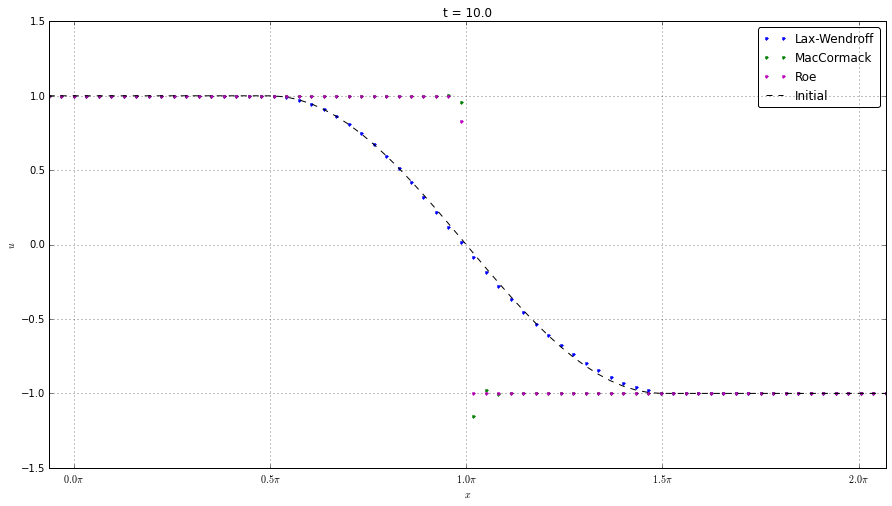

In [88]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(x, u_lw, 'b.', label='Lax-Wendroff')
ax.plot(x, u_mc, 'g.', label='MacCormack')
ax.plot(x, u_r, 'm.', label='Roe')
ax.set_ylim(-1.5, 1.5)
plot_opts(ax, max(x0))
ax.plot(x, signal(x), 'k--', label='Initial')
ax.set_title('t = %.1f' % tf)
ax.legend(fancybox=True, loc='best')
ax.set_xlabel('$x$')
ax.set_ylabel('$u$')
plt.show()
fig.savefig('burgers_inviscid.pdf')

In [52]:
!xdg-open .